In [2]:
from scPreGAN.model.util import load_anndata
from thesis import DATA_PATH, SAVED_RESULTS_PATH
from scPreGAN import Model

In [3]:
data_path = DATA_PATH / "pbmc" / "pbmc.h5ad"
pbmc_path = SAVED_RESULTS_PATH / "scPreGAN" / "pbmc"
model_path = pbmc_path / "model"
logging_path = pbmc_path / "log"

In [4]:
condition_key = 'condition'
condition = {
    'case': 'stimulated',
    'control': 'control'
}
cell_type_key = 'cell_type'
out_of_sample_prediction = True
cell_type= 'Dendritic'


adata_split, train_data = load_anndata(path=data_path,
                condition_key=condition_key,
                condition=condition,
                cell_type_key=cell_type_key,
                out_sample_prediction=out_of_sample_prediction,
                prediction_type=cell_type
                )
control_adata, perturb_adata = adata_split
control_pd, control_celltype_ohe_pd, perturb_pd, perturb_celltype_ohe_pd = train_data

In [5]:
# create model
n_features = control_pd.shape[1]
n_classes = control_adata.obs[cell_type_key].unique().shape[0]
print(n_features, n_classes)

model = Model(n_features=n_features, n_classes=n_classes, use_cuda=True)


6998 7
Random Seed:  3060
Successfully created the model


In [6]:
# training
from scPreGAN.model.scPreGAN import is_model_trained

REFRESH = False
load_model = is_model_trained(output_path=pbmc_path) and not REFRESH

model.train(train_data=train_data, output_path=pbmc_path, load_model=load_model)

[100/20000] adv_loss: 0.0073  recon_loss: 0.0586 encoding_loss: 0.0032 G_loss: 0.0691 D_A_loss: -0.3298  D_B_loss: -0.1128
[200/20000] adv_loss: 0.0046  recon_loss: 0.0498 encoding_loss: 0.0008 G_loss: 0.0552 D_A_loss: -0.2988  D_B_loss: 0.0918
[300/20000] adv_loss: 0.0047  recon_loss: 0.0518 encoding_loss: 0.0007 G_loss: 0.0573 D_A_loss: 0.0081  D_B_loss: -0.1489
[400/20000] adv_loss: 0.0077  recon_loss: 0.0478 encoding_loss: 0.0004 G_loss: 0.0559 D_A_loss: -0.4813  D_B_loss: -0.3440
[500/20000] adv_loss: 0.0069  recon_loss: 0.0500 encoding_loss: 0.0005 G_loss: 0.0573 D_A_loss: -0.6913  D_B_loss: -0.4302
[600/20000] adv_loss: 0.0084  recon_loss: 0.0465 encoding_loss: 0.0006 G_loss: 0.0555 D_A_loss: -0.4506  D_B_loss: -0.4338
[700/20000] adv_loss: 0.0090  recon_loss: 0.0475 encoding_loss: 0.0007 G_loss: 0.0571 D_A_loss: -0.8580  D_B_loss: -0.5385
[800/20000] adv_loss: 0.0102  recon_loss: 0.0494 encoding_loss: 0.0006 G_loss: 0.0602 D_A_loss: -1.1048  D_B_loss: -0.6464
[900/20000] adv_lo

In [7]:
# predicting
control_test_adata = control_adata[control_adata.obs["cell_type"] == "Dendritic"]


In [8]:
pred_perturbed_adata = model.predict(control_adata=control_test_adata,
                   cell_type_key=cell_type_key,
                   condition_key=condition_key)
pred_perturbed_adata

Predicting data finished


AnnData object with n_obs × n_vars = 670 × 6998
    obs: 'condition', 'cell_type'

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


saving dotplot to /g/kreshuk/katzalis/repos/thesis/saved_results/scPreGAN/pbmc/dotplot.pdf


Evalution saved /g/kreshuk/katzalis/repos/thesis/saved_results/scPreGAN/pbmc/ground_truth
Evalution saved /g/kreshuk/katzalis/repos/thesis/saved_results/scPreGAN/pbmc/predicted
Writing metrics to /g/kreshuk/katzalis/repos/thesis/saved_results/metrics.csv


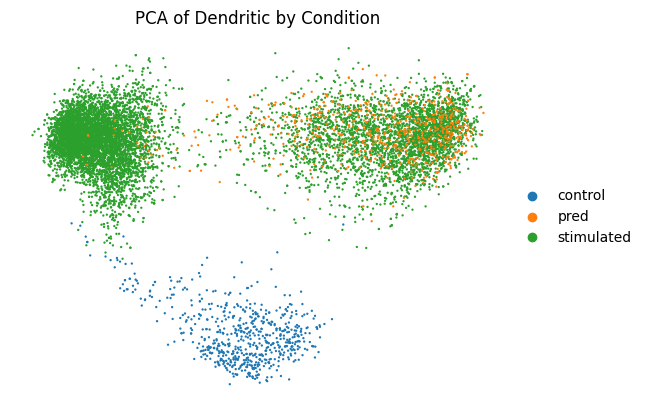

In [14]:
from thesis.evaluation import evaluation, ModelConfig


model_config = ModelConfig(
    model_name="scPreGAN",
    dataset_name="pbmc",
    experiment_name="",
    perturbation="ifn-b",
    cell_type_key="cell_type",
    output_path=pbmc_path
)

evaluation(
    model_config=model_config,
    input=control_test_adata,
    ground_truth=perturb_adata,
    predicted=pred_perturbed_adata,
    output_path=pbmc_path,
    save_plots=True,
    append_metrics=True
    )


Attempt to use the script from the reproducibility to check differences with the provided scPreGAN. For example, in the reproducibility training script there is `calc_gradient_penalty`, that doesn't exist in the scPreGAN repo.

In [7]:
from scPreGAN.reproducibility.scPreGAN_OOD_prediction import train_scPreGAN

opt = {
    'cuda': True,
    'dataPath': data_path,
    'checkpoint_dir': None,
    'condition_key': 'condition',
    'condition': {"case": "stimulated", "control": "control"},
    'cell_type_key': 'cell_type',
    'prediction_type': None,
    'out_sample_prediction': True,
    'manual_seed': 3060,
    'data_name': 'pbmc',
    'model_name': 'pbmc_OOD',
    'outf': pbmc_path,
    'validation': False,
    'valid_dataPath': None,
    'use_sn': True,
    'use_wgan_div': True,
    'gan_loss': 'wgan'
}


config = {
    "batch_size": 64,
    "lambda_adv": 0.001,
    "lambda_encoding": 0.1,
    "lambda_l1_reg": 0,
    "lambda_recon": 1,
    "lambta_gp": 1,
    "lr_disc": 0.001,
    "lr_e": 0.0001,
    "lr_g": 0.001,
    "min_hidden_size": 256,
    "niter": 20000,
    "z_dim": 16
}

opt['out_sample_prediction'] = True
opt['prediction_type'] = "Dendritic"


train_scPreGAN(opt=opt, config=config)

Random Seed:  3060
No validation.
feature length:  6998


/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1724789122112/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[100/20000] D_A_loss: -12.2384  D_B_loss: -6.4245 adv_loss: 0.0164  recon_loss: 0.0966 encoding_loss: 0.0112 G_loss: 0.1241
[200/20000] D_A_loss: -6.4438  D_B_loss: -6.2872 adv_loss: -0.0150  recon_loss: 0.0786 encoding_loss: 0.0097 G_loss: 0.0733
[300/20000] D_A_loss: -5.9235  D_B_loss: -6.2058 adv_loss: -0.0227  recon_loss: 0.0693 encoding_loss: 0.0085 G_loss: 0.0551
[400/20000] D_A_loss: -5.4887  D_B_loss: -5.7845 adv_loss: -0.0202  recon_loss: 0.0652 encoding_loss: 0.0072 G_loss: 0.0522
[500/20000] D_A_loss: -5.6279  D_B_loss: -5.2396 adv_loss: -0.0214  recon_loss: 0.0648 encoding_loss: 0.0069 G_loss: 0.0503
[600/20000] D_A_loss: -5.1888  D_B_loss: -4.8162 adv_loss: -0.0249  recon_loss: 0.0655 encoding_loss: 0.0049 G_loss: 0.0455
[700/20000] D_A_loss: -4.6342  D_B_loss: -4.5552 adv_loss: -0.0294  recon_loss: 0.0620 encoding_loss: 0.0043 G_loss: 0.0369
[800/20000] D_A_loss: -4.4008  D_B_loss: -4.2186 adv_loss: -0.0351  recon_loss: 0.0585 encoding_loss: 0.0039 G_loss: 0.0273
[900/200

KeyboardInterrupt: 